# Michigan's Spark Gap as a Structural Building Electrification Barrier: Online Companion Tool

This notebook accompanies a paper of the same name exploring how Michigan's high electricity prices and low fossil gas prices make it difficult to scale building electrification in pursuit of the State's decarbonization goals. 

The paper explores how adding electric load can improve system utilization, exert downward pressure on electricity rates, and narrow the spark gap. The computations behind the paper's results can be explored here. 

To use this tool, ...

## Setup

In [6]:
!pip -q install -r requirements.txt

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import us
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, HBox, VBox, Output, Label, Button
from collections import OrderedDict

from config import (
    data_year
    , sector
    , state_focus
    , peer_states
    , sectors
    , elec_exp_metric
    , exclude_states
    , building_type_options
    )


In [2]:
def state_name_to_code(state_name): 
    if state_name == 'District of Columbia':
        result = 'DC'
    elif state_name == 'US AVERAGE':
        result = 'US'
    else: 
        result_ = us.states.lookup(state_name)
        result = result_.abbr if result_ else None
    return result
  
def load_data(data_year): 
    df_raw = pd.read_csv(f'states-{data_year}.csv')
    
    # RATES, AND EXPENDITURES, AND LIKEWISE FOR NG
    metrics = [
        'Electricity Consumption per Customer - Residential Sector'
        , 'Average Price of Electricity - Residential Sector'
        , 'Electricity Expenditures per Household'
        , 'NG - Price - Residential Sector'
        , 'NG - Consumption per Customer - Residential Sector'
        , 'NG - Expenditures per Customer - Residential Sector'
        # CUSTOMER COUNT
        , 'NG - Number of Customers - Residential Sector'
        , 'Number of Electric Customers - Residential Sector'
        , 'Total Number of Occupied Housing Units'
    ]

    df = df_raw[df_raw['Metric Name'].isin(metrics)]
    df = df.pivot(index='State', columns='Metric Name', values='Metric Value')

    # convert gas units
    kwh_per_mcf = 1 / 0.003287225  # from MPSC Toolkit assumptions
    df['NG - Price - Residential Sector'] /= kwh_per_mcf
    df['NG - Consumption per Customer - Residential Sector'] *= kwh_per_mcf
    # calculate spark gap column
    df['Spark Gap'] = df['Average Price of Electricity - Residential Sector'].div(df['NG - Price - Residential Sector'])

    # in addition to per-household expenditures, calculate expenditures per customer: (revenue / sales) * (sales / number of customers) = expenditures per customer
    # this follows the same logic as the natural gas expenditures per customer. Not strictly correct in either case, because revenue per customer is not the same as exp/cust. 
    # this excludes taxes. But this is the best we can do with the available data, and taxes (while nontrivial) are policy-based and less tied to the regulatory process. 
    df['Electricity Expenditures per Customer - Residential Sector'] = df['Average Price of Electricity - Residential Sector'].multiply(df['Electricity Consumption per Customer - Residential Sector'])

    return df

def fit_trend(x, y, func_type):
    if func_type == 'inverse': 
        fit_func = lambda x, a, b: a / x + b
        # fit_func = lambda x, a, b, c: a / (x + b) + c
    elif func_type == 'linear': 
        fit_func = lambda x, a, b: a * x + b
  
    # Remove NaNs for fitting
    mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0)
    x_fit = x[mask]
    y_fit = y[mask]

    if func_type == 'inverse': 
        # p0 = (100, 100, 100)
        p0 = None
    else: 
        p0 = None

    popt, pcov = curve_fit(fit_func, x_fit, y_fit, p0=p0, maxfev=10000)

    # Generate trendline points
    x_line = np.linspace(x_fit.min(), x_fit.max(), 200)
    y_line = fit_func(x_line, *popt)
    
    # Calculate R^2
    residuals = y_fit - fit_func(x_fit, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
    r2 = 1 - (ss_res / ss_tot)    

    return popt, r2, x_line, y_line

def plot_bar(metric, data_year):
    # load data (uses existing load_data function)
    df = load_data(data_year)

    # select column and drop missing
    rates = df[[metric]].dropna().copy()
    rates.columns = ['rate']
    rates.sort_values('rate', inplace=True)

    # determine colors
    def color_for_state(name):
        if name == state_focus:
            return '#d62728'  # red
        if name == 'US AVERAGE':
            return '#2ca02c'  # green
        if name in peer_states:
            return '#ff7f0e'  # orange
        return '#1f77b4'      # blue

    colors = [color_for_state(s) for s in rates.index]

    # plot horizontal bar chart
    plt.figure(figsize=(8, 12))
    # sort descending so bars go from largest to smallest (top to bottom after invert_yaxis)
    rates = rates.sort_values('rate', ascending=False)
    colors = [color_for_state(s) for s in rates.index]
    bars = plt.barh(range(len(rates)), rates['rate'], color=colors, edgecolor='k', alpha=0.9)
    plt.yticks(range(len(rates)), [state_name_to_code(s) or s for s in rates.index], fontsize=10)
    plt.xlabel(metric)
    plt.title(f'{metric} by State ({data_year})')
    plt.grid(axis='x', linestyle='--', alpha=0.4)

    # annotate values on bars
    for i, (val, bar) in enumerate(zip(rates['rate'], bars)):
        plt.text(val + max(rates['rate']) * 0.005, bar.get_y() + bar.get_height() / 2,
                 f'{val:.3f}', va='center', fontsize=9)

    plt.gca().invert_yaxis()  # highest price on top
    plt.tight_layout()
    plt.show()

def plot_regression(iv, dv, data_year, func_type, exclude_states=[], title=None, labels=[], subplots=False): 
    df = load_data(data_year)

    # Get state codes for plotting
    df['State Code'] = df.index.map(state_name_to_code)

    # drop the rows where 'State Code' is in the excluded states
    if exclude_states:
        df = df[~df['State Code'].isin(exclude_states)]

    if not subplots: 
        plt.figure(figsize=(10, 7))
        
    for state, row in df.iterrows():
        plt.scatter(
            row[iv],
            row[dv],
            s=140,
            color=('#d62728' if state == state_focus else
               '#ff7f0e' if state in peer_states else
               '#2ca02c' if state == 'US AVERAGE' else
               '#1f77b4'),
            edgecolor='k',
            alpha=0.7,
            zorder=3
        )
        plt.text(
            row[iv],
            row[dv],
            df.loc[state, 'State Code'],
            fontsize=10,
            ha='center',
            va='center',
            fontweight='bold'
        )

    x = df[iv].values
    y = df[dv].values

    popt, r2, x_line, y_line = fit_trend(x, y, func_type)
    
    if func_type == 'inverse': 
        label = f'y = {popt[0]:.3f}/x + {popt[1]:.3f}'
    elif func_type == 'linear': 
        label = f'y = {popt[0]:.3f}x  + {popt[1]:.3f}'
   
    plt.plot(x_line, y_line, color='black', linestyle='--', label=label)
    # Add summary info
    plt.legend(title=f'Trend: $R^2$ = {r2:.3f}')

    if not labels: 
        plt.xlabel(iv)
        plt.ylabel(dv)
    else: 
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    if title: 
        plt.title(f'{title} ({data_year})')
    else: 
        plt.title(f'{dv} vs {iv} ({data_year})')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if not subplots: 
        plt.show()

# load data for regressions
dfr = load_data(data_year)
dfr['State Code'] = dfr.index.map(state_name_to_code)
dfr = dfr[~dfr['State Code'].isin(exclude_states)]
spark_gap_mi = dfr.loc[state_focus, 'Spark Gap']

# get parameters for each regression
(a_e, F_e), r2_e, x_line_e, y_line_e = fit_trend(
    dfr['Electricity Consumption per Customer - Residential Sector'].values
    , dfr[elec_exp_metric].values
    , 'linear'
)
(a_g, F_g), r2_g, x_line_g, y_line_g = fit_trend(
    dfr['NG - Consumption per Customer - Residential Sector'].values
    , dfr['NG - Expenditures per Customer - Residential Sector'].values
    , 'linear'
)

# define remaining variables for Michigan electricity and gas data
C_e = dfr.loc[state_focus, 'Electricity Consumption per Customer - Residential Sector']
E_e = dfr.loc[state_focus, 'Electricity Expenditures per Household']
C_g = dfr.loc[state_focus, 'NG - Consumption per Customer - Residential Sector']
E_g = dfr.loc[state_focus, 'NG - Expenditures per Customer - Residential Sector']

# assume an efficiency advantage for electricity vs gas
eta_eg = 3

# case 1: constant gas rates
def delta_G_1(delta_C_e): 
    return (C_g / E_g) * ((a_e * C_e - E_e)/ C_e**2) * delta_C_e

def delta_C_e_1(delta_G): 
    return (((C_g / E_g) * ((a_e * C_e - E_e) / C_e**2))**-1) * (delta_G)

# case 2: incremental gas rates
def delta_G_2(delta_C_e): 
    return ((C_g / E_g) * ((a_e * C_e - E_e) / C_e**2) + eta_eg * (C_g**2 / E_g**2) * (E_e / C_e) * ((a_g * C_g - E_g) / C_g**2)) * delta_C_e

def delta_C_e_2(delta_G): 
    return (((C_g / E_g) * ((a_e * C_e - E_e) / C_e**2) + eta_eg * (C_g**2 / E_g**2) * (E_e / C_e) * ((a_g * C_g - E_g) / C_g**2))**-1) * delta_G

# define statewide number of residential electric customers
customer_count = dfr.loc[state_focus, 'Number of Electric Customers - Residential Sector']

# EVI-Pro Vehicle Load Profile, Annual Electricity Demand
df_evi = pd.read_csv(os.path.join('nrel data', 'load-profile-per-vehicle-Lansing_MI-h.csv'), index_col=0, parse_dates=True)
annual_charging_demand_per_vehicle = df_evi.sum().sum()

# get current EV and total vehicle counts in Michigan, courtesy of MDOS
df_evs = pd.read_csv(os.path.join('mdos data', 'ev_counts_by_county.csv'))
df_total_vehicles = pd.read_excel(os.path.join('mdos data', 'Vehicle Registrations by County.xlsx'), skipfooter=1)
current_ev_count = df_evs[['Battery Electric', 'Plugin Hybrid Electric']].sum().sum()
total_vehicle_count = df_total_vehicles['Passenger Active'].sum()

# define function to calculate change in consumption per customer from electrifying a fraction of the vehicle stock
def delta_C_from_ev_load(ev_fraction): 
    current_ev_penetration = current_ev_count / total_vehicle_count
    if ev_fraction <= current_ev_penetration: 
        return 0
    additional_evs = (ev_fraction - current_ev_penetration) * total_vehicle_count
    incremental_load = annual_charging_demand_per_vehicle * additional_evs
    incremental_load_per_customer = incremental_load / customer_count
    return incremental_load_per_customer

# function to load a ResStock profile for a given building type. 
def read_resstock_profile(building_type):
    # load resstock profile for the specified building type
    file_name = f'up00-mi-{building_type}.csv'
    df = pd.read_csv(os.path.join('nrel data', 'res', file_name), index_col='timestamp', parse_dates=True)
    
    # change index so all timestamps are in one year
    df.index -= pd.Timedelta(minutes=15)

    # get units represented
    units_represented = df['units_represented'].values[0]

    # filter out columns to only outputs in kwh
    df = df.filter(like='out').filter(like='kwh')

    # drop columns containing 'site_energy', 'total', or 'net'
    df = df.drop(columns=df.filter(like='site_energy').columns)
    df = df.drop(columns=df.filter(like='total').columns)
    df = df.drop(columns=df.filter(like='net').columns)
    # resample to hourly level
    df = df.resample('h').sum()

    #re-insert units represented
    df.insert(0, 'units_represented', units_represented)

    return df

# save all the resstock profiles in a dictionary for quick access
resstock_profiles = {bt: read_resstock_profile(bt) for bt in building_type_options}

# functions to convert building fossil fuel load to equivalent electric load. 
def cop_mapping(temp): 
    """
    Given a temperature (in Celsius), this function uses the COP specs from the Mitsubishi PVA-A42AA7 heat pump model to determine 
    the heat pump coefficient of performance to use at that temperature. 
    This function is adapted from the MPSC Toolkit helper_functions. 
    """
    hp_cop_specs = { # temps in F; COPs from model specs for Mitsubishi PVA-A42AA7 (specific heat pump model)
        47: 3.7
        , 17: 2.1
        , 5: 1.9
        , -13: 1.6
    }

    # Convert Fahrenheit keys to Celsius
    hp_cop_specs = {round((f - 32) * 5 / 9, 1): cop for f, cop in hp_cop_specs.items()}

    # create interpolation function
    cop_temp_mapping = interp1d(
        list(hp_cop_specs.keys())
        , list(hp_cop_specs.values())
        , kind='linear'
        , fill_value='extrapolate'
    )

    cop_result = cop_temp_mapping(temp)

    return cop_result

def delta_C_from_building_load(building_types, fraction=1, fuel_types='all', end_uses='all'): 
    """
    Convert fossil-fuel end-use hourly demand to equivalent electric demand.

    Parameters
    ----------
    df_demand : pandas.DataFrame
        Hourly-indexed dataframe of fossil-fuel end-use energy consumption in kWh.
        Column names should include end-use identifiers (e.g. 'heating', 'hot_water',
        'clothes_dryer', 'range_oven', 'interior_equipment', 'water_systems', etc.).
    fraction : float, optional
        Fraction of the selected demand to convert (0.0 - 1.0). Default is 1 (all demand).
    fuel_types : 'all' or list-like, optional
        If 'all', do not filter by fuel type. If list-like, only keep columns whose
        names contain any of the provided substrings (case-sensitive).
    end_uses : 'all' or list-like, optional
        If 'all', do not filter by end use. If list-like, only keep columns whose
        names contain any of the provided substrings (case-sensitive).

    Returns
    -------
    pandas.DataFrame
        Hourly-indexed dataframe of estimated electric demand in kWh after applying
        appropriate coefficients of performance (COPs) or appliance efficiencies.

    Behavior / Notes
    ----------------
    - Non-weather-sensitive end uses are converted by dividing by fixed COP/efficiency:
        clothes_dryer -> COP = 3
        hot_water, water_systems -> COP = 3.5
        range_oven, interior_equipment -> efficiency ≈ 0.85 (treated like COP < 1)
    - Heating is weather-sensitive: the function reads the weather file
      'nrel data/G2601630_2018_wayne_county_weather.csv', extracts hourly dry-bulb
      temperature (°C) and maps it to a COP using cop_mapping(temp). Heating demand
      is divided hour-by-hour by that COP.
    - The function multiplies the (filtered) demand by fraction before conversion.
    - The caller is responsible for providing df_demand with an hourly DatetimeIndex
      that aligns with the weather file (the implementation shifts the weather index
      by one hour: date_time -> date_time - 1 hour).
    - Missing or unexpected column names will simply be ignored by the filtering
      logic; ensure expected end-use substrings are present.

    Examples
    --------
    >>> # convert all natural-gas heating + hot water demand to electric demand for 50% of units
    >>> df_el = convert_demand(df_demand, fraction=0.5,
    ...                        fuel_types=['natural_gas'], end_uses=['heating', 'hot_water'])
    """
    # load data from ResStock, summing across the selected building types to get a single demand profile.
    df = sum(resstock_profiles[bt] for bt in building_types)

    # get the units represented
    units_represented = df['units_represented'].values[0]
    df = df.drop(columns=['units_represented'])

    # keep just the fossil end use consumption
    df = df.drop(columns=df.filter(like='electricity').columns)

    # convert consumption to demand
    ff_efficiency = 0.86
    df *= ff_efficiency

    # slice along fuel_type axis
    if fuel_types != 'all': 
        df = df[[col for col in df.columns if any(ft in col for ft in fuel_types)]]
    
    # slice along end_use axis
    if end_uses != 'all': 
        df = df[[col for col in df.columns if any(eu in col for eu in end_uses)]]

    # cut df down to the desired fraction of the demand
    df *= fraction

    # convert demand into electricity requirement for each end use
    for col in df.columns: 
        # non-heating columns are not weather-sensitive and have a straightforward COP to apply. 
        if 'heating' not in col: 
            if 'clothes_dryer' in col: 
                cop = 3
            elif 'hot_water' in col: 
                cop = 3.5
            elif 'range_oven' in col: 
                cop = 0.85
            elif 'interior_equipment' in col: 
                cop = 0.85
            elif 'water_systems' in col: 
                cop = 3.5
            df[col] /= cop
        else: # deal with heating by applying a weather-specific COP in each hour
            df_temp = pd.read_csv('nrel data/G2601630_2018_wayne_county_weather.csv')
            df_temp.index = pd.to_datetime(df_temp['date_time']) - pd.Timedelta(hours=1)
            df_temp = df_temp['Dry Bulb Temperature [°C]'].to_frame(name='tempC')
            df_temp['cop'] = df_temp['tempC'].map(cop_mapping)
            df[col] /= df_temp['cop']

    # sum the columns to get total electric demand. sum across rows to get annual incremental load. divide by customer count. 
    return df.sum().sum() / customer_count


## Interactive tool to estimate incremental load and spark gap reduction from different sources of electrification

In [3]:
# Define sliders for electrification percentages
ev_fraction_slider = FloatSlider(value=0.5, min=0.02, max=1.0, step=0.01, description='Vehicles:')
propane_slider = FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Propane:')
natural_gas_slider = FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Fossil Gas:')
fuel_oil_slider = FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Fuel Oil:')

# Define checkboxes for end uses
end_use_options = ['heating', 'hot_water', 'clothes_dryer', 'range_oven']
natural_gas_checkboxes = [Checkbox(value=True, description=eu) for eu in end_use_options + ['other']]
propane_checkboxes = [Checkbox(value=True, description=eu) for eu in end_use_options]
fuel_oil_checkboxes = [Checkbox(value=True, description=eu) for eu in ['heating', 'hot_water']]

# define building type options
building_type_checkboxes = [Checkbox(value=True, description=bt.replace('_', ' ').replace('plus', '+').capitalize()) for bt in building_type_options]
building_type_box = VBox([Label("Building Types:")] + building_type_checkboxes)

# Define slider for coordinated electrification percentage
random_slider = VBox([
    Label("Fraction of fossil gas electrification happening randomly:"),
    FloatSlider(
        value=1.0, 
        min=0.0, 
        max=1.0, 
        step=0.01, 
        style={'description_width': 'initial'},
    )
])

# Create output area
output = Output()

# Function to collect inputs and run calculations
def run_calculations(change=None):
    with output:
        output.clear_output()

        print('INCREMENTAL LOADS:')

        # Collect EV load percentage
        ev_fraction = ev_fraction_slider.value
        ev_load = delta_C_from_ev_load(ev_fraction)
        ev_delta_g = delta_G_1(ev_load)
        
        # Initialize inc. loads, labels, and delta_G values as only containing the EV information
        incremental_loads = [ev_load]
        labels = ['vehicles']
        delta_G_values = [ev_delta_g]

        # Get checked building types from building_type_box
        selected_building_types = [
            cb.description.replace(' ', '_').replace('+', 'plus').lower()
            for cb in building_type_checkboxes if cb.value
        ]

        for fuel_type, slider, checkboxes in zip(
            ['natural_gas', 'propane', 'fuel_oil'],
            [natural_gas_slider, propane_slider, fuel_oil_slider],
            [natural_gas_checkboxes, propane_checkboxes, fuel_oil_checkboxes]
        ):
            fraction = slider.value
            selected_end_uses = [cb.description for cb in checkboxes if cb.value]
            if len(selected_end_uses) == len(checkboxes):
                end_uses = 'all'
            else:
                end_uses = selected_end_uses
            if end_uses:
                load = delta_C_from_building_load(
                    building_types=selected_building_types,
                    fraction=fraction, 
                    fuel_types=[fuel_type], 
                    end_uses=end_uses
                )
            if fuel_type == 'natural_gas': 
                # split NG electrification into random vs coordinated
                random_fraction = random_slider.children[1].value
                random_load = load * random_fraction
                coordinated_load = load - random_load

                # add incremental load, label, and delta_G for random portion
                incremental_loads.append(random_load)
                labels.append(f"gas (random)")
                delta_G_values.append(delta_G_2(random_load))
                
                # add incremental load, label, and delta_G for coordinated portion
                incremental_loads.append(coordinated_load)
                labels.append(f"gas (coordinated)")
                delta_G_values.append(delta_G_1(coordinated_load))
            else:
                incremental_loads.append(load)
                labels.append(f"{fuel_type}")
                delta_G_values.append(delta_G_1(load))
        
        # Create a figure with 1 row and 2 columns of subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))

        # Plot stacked bar chart for the incremental loads in the first subplot
        bottom = 0
        top = spark_gap_mi
        for load, label, delta_G in zip(incremental_loads, labels, delta_G_values):
            # first, print the numbers
            print(f'{label:<20}: {load:>10.0f} kWh per customer. \tSpark gap reduction: {abs(delta_G):>10.4f}')

            # plot the incremental loads as a stacked bar
            axes[0].bar(["Incremental Load"], [load], bottom=bottom, edgecolor='k', alpha=0.8, label=label)
            bottom += load

            # plot the delta_G values as a stacked bar
            axes[1].bar(['Change in Spark Gap'], [delta_G], bottom=top - spark_gap_mi, label=label)
            top += delta_G

        # Add a horizontal line at y=0 with the current spark gap label
        axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1].text(0, 0.1, f"{data_year} Spark Gap: {spark_gap_mi:.2f}", color='black', ha='center', va='bottom')

        # add a horizontal line at y=-eta_eg with "target spark gap" as the label
        axes[1].axhline(y=eta_eg-spark_gap_mi, color='k', linestyle='--', linewidth=3)
        axes[1].text(0, eta_eg - spark_gap_mi + 0.1, f'Target Spark Gap: {eta_eg}', color='k', fontsize=12, ha='center')

        # y-axis units
        axes[0].set_ylabel("kWh per customer")
        axes[1].set_ylabel("Dimensionless")

        # Add a single legend for the entire figure
        handles, labels_ = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=2)

        # add figure title
        fig.suptitle('Effect of Incremental Loads on Spark Gap')

        plt.show()

# Layout for the widgets
propane_box = VBox([Label("Propane End Uses:")] + propane_checkboxes)
natural_gas_box = VBox([Label("Fossil Gas End Uses:")] + natural_gas_checkboxes + [random_slider])
fuel_oil_box = VBox([Label("Fuel Oil End Uses:")] + fuel_oil_checkboxes)
sliders_box = VBox([ev_fraction_slider, natural_gas_slider, propane_slider, fuel_oil_slider])
checkboxes_box = HBox([natural_gas_box, propane_box, fuel_oil_box])

# Add an "Apply Changes" button
apply_button = Button(description="Apply Changes", button_style='primary')

# Only run calculations when button is clicked
apply_button.on_click(run_calculations)

ui = VBox([
    Label("Select Electrification Percentages: "),
    sliders_box,
    building_type_box,
    checkboxes_box,
    apply_button,
    output
])

display(ui)


## Supplemental Calculations

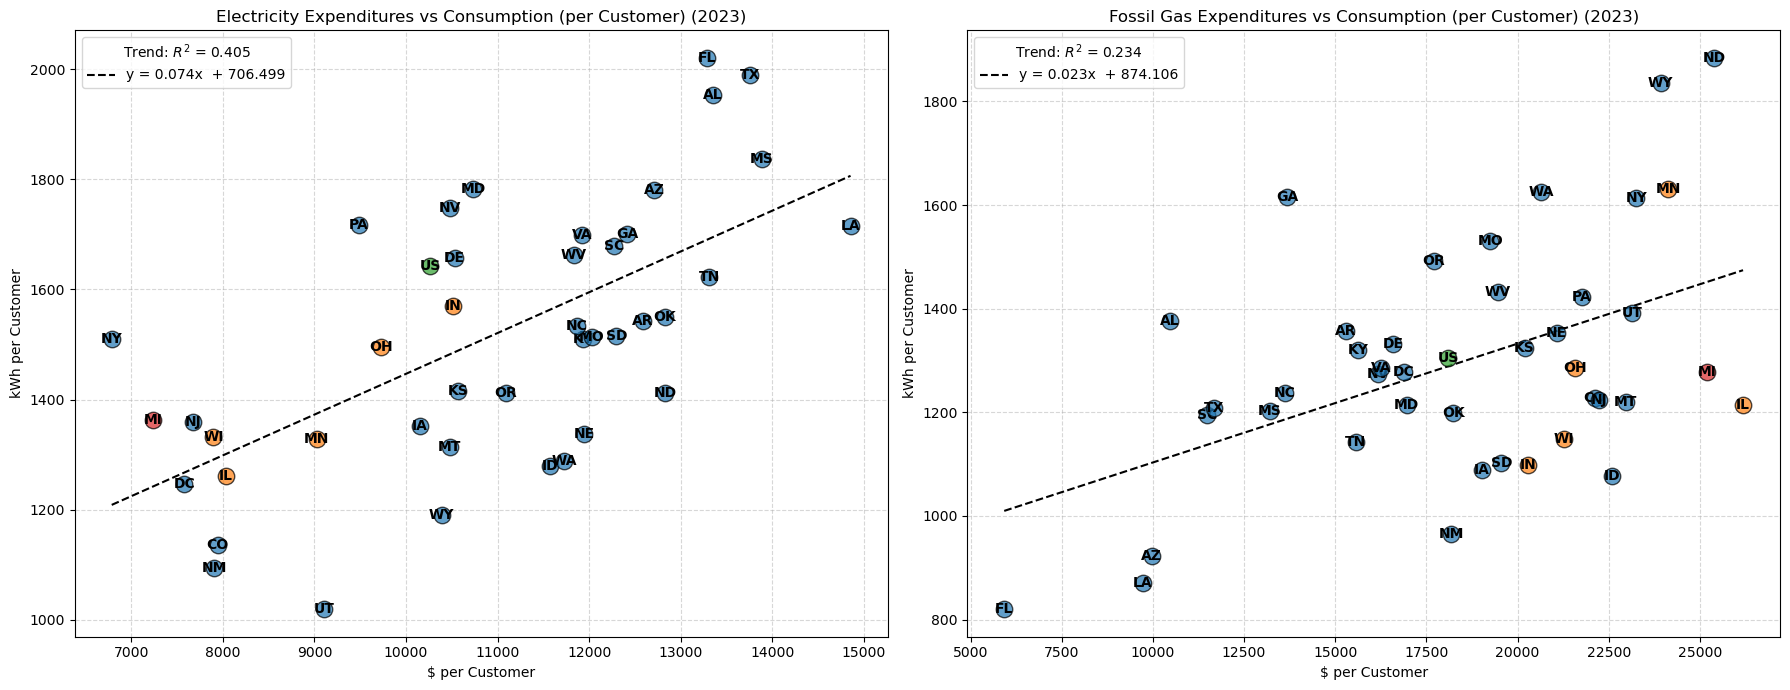

In [5]:
regressions = [
    (
        'Electricity Consumption per Customer - Residential Sector',
        elec_exp_metric,
        'linear',
        'Electricity Expenditures vs Consumption (per Customer)'
    ),
    (
        'NG - Consumption per Customer - Residential Sector',
        'NG - Expenditures per Customer - Residential Sector',
        'linear',
        'Fossil Gas Expenditures vs Consumption (per Customer)'
    )
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Loop over each regression type and fill both columns
for i, (iv, dv, func_type, title) in enumerate(regressions):
    ax = axes[i]
    plt.sca(ax)  # set current axis for plot_regression to use

    # Temporarily suppress plt.show() behavior
    plt.ioff()
    plot_regression(
        iv=iv,
        dv=dv,
        data_year=data_year,
        func_type=func_type,
        exclude_states=exclude_states,
        title=title,
        subplots=True
        , labels=['$ per Customer', 'kWh per Customer']
    )
    plt.ion()

plt.tight_layout()
plt.show()


### Deriving the change in spark gap

The change in spark gap will be a function of the change in electricity consumption per household. Let's define the following variables: 

- r<sub>e</sub> := electric rate, $/kWh
- r<sub>g</sub> := gas rate, $/kWh
- G = spark gap := r<sub>e</sub> / r<sub>g</sub>
- E<sub>e</sub> := Electricity Expenditures per Customer ($/customer) = Revenue / Customer Count in EIA861
- E<sub>g</sub> := NG Expenditures per Customer ($/customer) = Revenue / Customer Count in EIA176
- C<sub>e</sub> := Electricity Consumption per Customer (kWh/customer) = Sales / Customer Count in EIA861
- C<sub>g</sub> := NG Consumption per Customer (kWh/customer) = Sales / Customer Count in EIA176

From the expenditures vs consumption regressions above, we get the following relationships: 

$$
E_e = a_e C_e + F_e
\\
E_g = a_g C_g + F_e
$$

The slopes a<sub>e</sub> and a<sub>g</sub> can be interpreted as the incremental costs of energy (i.e. power supply and gas supply), and the intercepts F<sub>e</sub> and F<sub>g</sub> can be interpreted as the fixed costs per customer (i.e. the distribution costs). 

The equation: 

$$
G = \frac{r_e}{r_g}
$$

is the foundation of the following calculations. When we differentiate, we'll end up with expressions involving the change in electricity and gas consumption per customer, 

$$
\delta C_e, \text{  }\delta C_g
$$

Introduce one more variable: 

$$
\eta_{eg} := \text{ the efficiency advantage of electricity over gas}
$$

Then, whenever electricity consumption replaces gas consumption: 

$$
\delta C_g = -\eta_{eg}\delta C_e
$$

For our purposes: 
$$
\eta_{eg} = 3
$$

The expressions will also involve changes to electricity and gas expenditures per customer. Using the regressions: 

$$
\delta E_e = a_e\delta C_e
\\
\delta E_g = a_g\delta C_g = -\eta_{eg}a_g\delta C_e
$$

Finally, let's quickly derive the regression-based expressions for change in rates. The following applies to either gas or electricity: 

$$
\delta r = \delta (\frac{E}{C}) = \frac{C\delta E - E\delta C}{C^2} = \frac{C(a\delta C) - E\delta C}{C^2} = \delta C(\frac{aC - E}{C^2})
$$

#### Case 1: gas rates are fixed

$$
\delta G = \delta (\frac{r_e}{r_g}) = \frac{1}{r_g}\delta r_e = \frac{C_g}{E_g}(\frac{a_e C_e - E_e}{C_e^2})\delta C_e
$$

#### Case 2: gas rates increase 

$$
\delta G = \delta (\frac{r_e}{r_g}) = \frac{r_g \delta r_e - r_e \delta r_g}{r_g^2} = (\frac{C_g}{E_g})^2 \times (r_g \delta r_e - r_e \delta r_g) 
\\ 
= (\frac{C_g}{E_g})^2 \times (\frac{E_g}{C_g}(\frac{a_eC_e - E_e}{C_e^2})\delta C_e - \frac{E_e}{C_e}\delta C_e(\eta_{eg})\frac{a_gC_g - E_g}{C_g^2})
\\

= \delta C_e [\frac{C_g}{E_g}\frac{a_eC_e - E_e}{C_e} + \eta_{eg}\frac{C_g^2 E_e}{E_g^2 C_e}\frac{a_gC_g - E_g}{C_g^2}]
$$


These are the expressions that define a change in the spark gap given a change in electricity consumption. They can be easily inverted to determine how much additional consumption is needed to achieve a given change in the spark gap. These equations are all implemented in the setup phase of this notebook. 